# Without Augmentation

In [10]:
# import libraries

import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import timm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Define dataset paths and parameters
DATASET_PATH = "/kaggle/input/cse465-dataset/data"
BATCH_SIZE =32
EPOCHS = 15
IMG_SIZE = 224  # Changed to 224x224 pixels
NUM_CLASSES = 6
NUM_WORKERS = 2
PATIENCE = 3

In [3]:
# Define transformations with preprocessing steps
# Augmentations are comment out
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),          # Resize to 224x224 pixels
    transforms.CenterCrop(IMG_SIZE),                  # Crop to focus on central region
    transforms.Grayscale(num_output_channels=3),      # Convert to grayscale, keep 3 channels
    #transforms.RandomHorizontalFlip(),                # Data augmentation
    #transforms.RandomRotation(15),                    # Data augmentation
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Data augmentation
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),          # Resize to 224x224 pixels
    transforms.CenterCrop(IMG_SIZE),                  # Crop to focus on central region
    transforms.Grayscale(num_output_channels=3),      # Convert to grayscale, keep 3 channels
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [4]:
# Load dataset
dataset = datasets.ImageFolder(root=DATASET_PATH, transform=train_transform)
class_names = dataset.classes  # Get class names from folder names
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
test_dataset.dataset.transform = test_transform

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [12]:
# Function to print model size and parameters
def print_model_info(model, model_name):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_params = trainable_params + non_trainable_params
    
    temp_path = f"temp_{model_name}.pth"
    torch.save(model.state_dict(), temp_path)
    model_size = os.path.getsize(temp_path) / (1024 * 1024)  # Size in MB
    os.remove(temp_path)
    
    print(f"\n{model_name}:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Non-trainable parameters: {non_trainable_params:,}")
    print(f"  Model size: {model_size:.2f} MB")

In [13]:
##### Freeze layers
def freeze_layers(model, model_name):
    if "resnet" in model_name.lower():
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
    elif "mobilenet" in model_name.lower():
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif "efficientnet" in model_name.lower():
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():  # Corrected to use classifier
            param.requires_grad = True
    elif "densenet" in model_name.lower():
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif "vit" in model_name.lower():
        for param in model.parameters():
            param.requires_grad = False
        for param in model.head.parameters():
            param.requires_grad = True
    elif "shufflenet" in model_name.lower():
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
    elif "squeezenet" in model_name.lower():
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier[1].parameters():
            param.requires_grad = True
    elif "tinynet" in model_name.lower():
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif "lcnet" in model_name.lower():
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif "hardcorenas" in model_name.lower():
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
    
    return model

In [12]:
####### Modify final layer

def modify_model(model, num_classes):
    if isinstance(model, models.resnet.ResNet):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif isinstance(model, models.mobilenet.MobileNetV2):
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif isinstance(model, models.efficientnet.EfficientNet):
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif isinstance(model, models.densenet.DenseNet):
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif "vit" in model.__class__.__name__.lower():
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    elif isinstance(model, models.shufflenetv2.ShuffleNetV2):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif isinstance(model, models.squeezenet.SqueezeNet):
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model.num_classes = num_classes
    elif isinstance(model, models.mobilenet.MobileNetV3):
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    elif "tinynet" in model.__class__.__name__.lower():
        model.head = nn.Linear(model.head.in_features, num_classes)
    elif "lcnet" in model.__class__.__name__.lower():
        model.head = nn.Linear(model.head.in_features, num_classes)
    elif "hardcorenas" in model.__class__.__name__.lower():
        model.head = nn.Linear(model.head.in_features, num_classes)
    
    return model

In [14]:
# Training function with timing and loss/accuracy tracking
def train_model(model, train_loader, test_loader, criterion, optimizer, device, patience):
    best_acc = 0.0
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    total_start_time = time.time()
    
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Evaluate on training and test sets
        model.eval()
        train_acc = evaluate_model(model, train_loader, device)[0]
        val_acc = evaluate_model(model, test_loader, device)[0]
        val_loss = criterion(outputs, labels).item()  # Approximate val loss
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")
        
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{model.__class__.__name__}.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    
    total_time = time.time() - total_start_time
    print(f"Total training time: {total_time:.2f}s")
    
    return train_losses, val_losses, train_accuracies, val_accuracies


In [15]:
# Evaluation function
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, precision, recall, f1, cm


In [16]:
# Initialize models

models_dict = {
    "ShuffleNetV2_0_5": models.shufflenet_v2_x0_5(weights='IMAGENET1K_V1'),
    #"SqueezeNet1_1": models.squeezenet1_1(weights='IMAGENET1K_V1'),
    #"SqueezeNet1_0": models.squeezenet1_0(weights='IMAGENET1K_V1'),
    "MobileNetV3_Small": models.mobilenet_v3_small(weights='IMAGENET1K_V1'),
    #"MobileNetV3_Small_050": timm.create_model('mobilenetv3_small_050', pretrained=True),
    #"LCNet_050": timm.create_model('lcnet_050', pretrained=True),
    #"MobileNetV3_Small_075": timm.create_model('mobilenetv3_small_075', pretrained=True),
    #"TinyNet_E": timm.create_model('tinynet_e', pretrained=True),
    "MobileNetV2": models.mobilenet_v2(weights='IMAGENET1K_V1'),
    #"LCNet_075": timm.create_model('lcnet_075', pretrained=True),
    #"TinyNet_B": timm.create_model('tinynet_b', pretrained=True),
    "EfficientNet-B0": models.efficientnet_b0(weights='IMAGENET1K_V1'),
    #"HardcoreNAS_A": timm.create_model('hardcorenas_a', pretrained=True),
    #"TinyNet_A": timm.create_model('tinynet_a', pretrained=True),
    "DenseNet-121": models.densenet121(weights='IMAGENET1K_V1'),
    #"ResNet-50": models.resnet50(weights='IMAGENET1K_V2'),
    #"ViT-B-16": timm.create_model('vit_base_patch16_224', pretrained=True)
}

In [16]:
for model_name, model in models_dict.items():
    model = modify_model(model, NUM_CLASSES)
    model = freeze_layers(model, model_name)
    model = model.to(device)
    
    # Print model info
    print_model_info(model, model_name)


ShuffleNetV2_0_5:
  Total parameters: 347,942
  Trainable parameters: 6,150
  Non-trainable parameters: 341,792
  Model size: 1.47 MB

MobileNetV3_Small:
  Total parameters: 1,524,006
  Trainable parameters: 596,998
  Non-trainable parameters: 927,008
  Model size: 5.94 MB

MobileNetV2:
  Total parameters: 2,231,558
  Trainable parameters: 7,686
  Non-trainable parameters: 2,223,872
  Model size: 8.75 MB

EfficientNet-B0:
  Total parameters: 4,015,234
  Trainable parameters: 7,686
  Non-trainable parameters: 4,007,548
  Model size: 15.61 MB

DenseNet-121:
  Total parameters: 6,960,006
  Trainable parameters: 6,150
  Non-trainable parameters: 6,953,856
  Model size: 27.13 MB



Training ShuffleNetV2_0_5...
Epoch 1/15, Loss: 1.3876, Train Acc: 0.9922, Val Acc: 0.9933, Time: 108.59s
Epoch 2/15, Loss: 0.8398, Train Acc: 0.9927, Val Acc: 0.9938, Time: 70.92s
Epoch 3/15, Loss: 0.5541, Train Acc: 0.9957, Val Acc: 0.9950, Time: 71.65s
Epoch 4/15, Loss: 0.3965, Train Acc: 0.9967, Val Acc: 0.9967, Time: 72.85s
Epoch 5/15, Loss: 0.3022, Train Acc: 0.9977, Val Acc: 0.9967, Time: 70.61s
Epoch 6/15, Loss: 0.2381, Train Acc: 0.9978, Val Acc: 0.9967, Time: 71.00s
Epoch 7/15, Loss: 0.1944, Train Acc: 0.9981, Val Acc: 0.9971, Time: 71.55s
Epoch 8/15, Loss: 0.1598, Train Acc: 0.9984, Val Acc: 0.9975, Time: 70.61s
Epoch 9/15, Loss: 0.1360, Train Acc: 0.9989, Val Acc: 0.9975, Time: 70.28s
Epoch 10/15, Loss: 0.1163, Train Acc: 0.9988, Val Acc: 0.9979, Time: 71.82s
Epoch 11/15, Loss: 0.1002, Train Acc: 0.9990, Val Acc: 0.9988, Time: 72.07s
Epoch 12/15, Loss: 0.0873, Train Acc: 0.9990, Val Acc: 0.9983, Time: 71.36s
Epoch 13/15, Loss: 0.0759, Train Acc: 0.9992, Val Acc: 0.9992, Tim

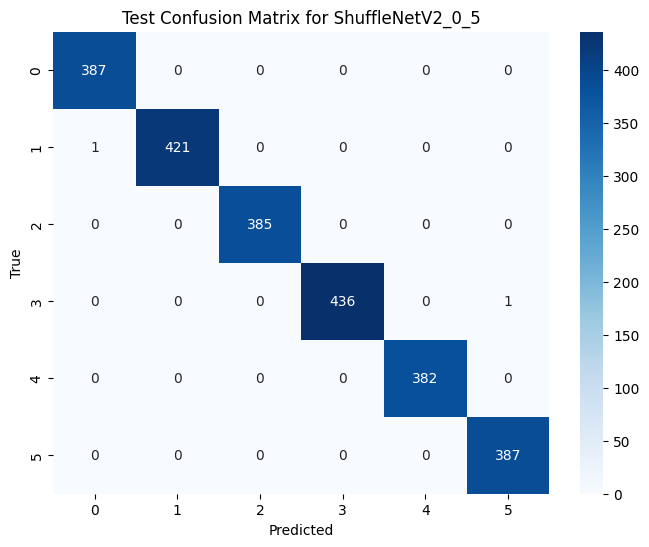


Training MobileNetV3_Small...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15, Loss: 0.0914, Train Acc: 0.3419, Val Acc: 0.3250, Time: 72.15s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/15, Loss: 0.0190, Train Acc: 0.8714, Val Acc: 0.8675, Time: 71.86s
Epoch 3/15, Loss: 0.0148, Train Acc: 0.9985, Val Acc: 0.9962, Time: 72.55s
Epoch 4/15, Loss: 0.0092, Train Acc: 1.0000, Val Acc: 0.9992, Time: 71.27s
Epoch 5/15, Loss: 0.0083, Train Acc: 0.9998, Val Acc: 0.9996, Time: 71.33s
Epoch 6/15, Loss: 0.0025, Train Acc: 0.9999, Val Acc: 1.0000, Time: 71.35s
Epoch 7/15, Loss: 0.0157, Train Acc: 1.0000, Val Acc: 1.0000, Time: 72.93s
Epoch 8/15, Loss: 0.0022, Train Acc: 0.9999, Val Acc: 0.9996, Time: 70.51s
Epoch 9/15, Loss: 0.0030, Train Acc: 0.9998, Val Acc: 0.9996, Time: 71.76s
Early stopping triggered
Total training time: 645.91s
  Final Training Accuracy: 0.9998
  Highest Training Accuracy: 1.0000

Test Metrics for MobileNetV3_Small:
  Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


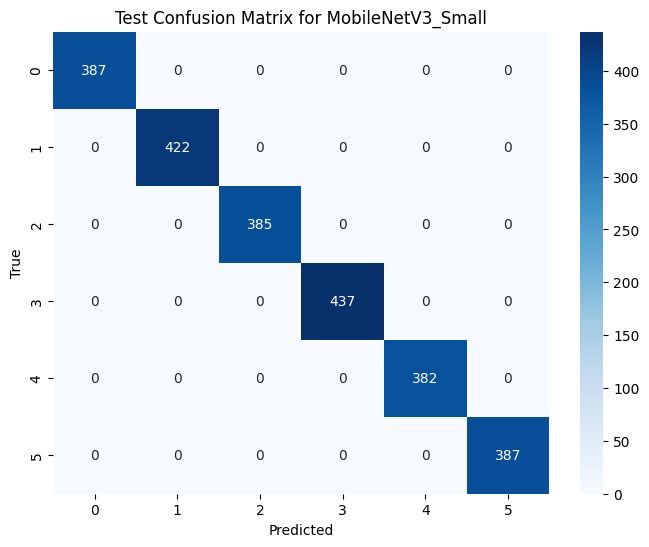


Training MobileNetV2...
Epoch 1/15, Loss: 0.2325, Train Acc: 0.9988, Val Acc: 0.9996, Time: 72.38s
Epoch 2/15, Loss: 0.0431, Train Acc: 0.9999, Val Acc: 1.0000, Time: 74.02s
Epoch 3/15, Loss: 0.0249, Train Acc: 1.0000, Val Acc: 1.0000, Time: 74.38s
Epoch 4/15, Loss: 0.0164, Train Acc: 1.0000, Val Acc: 1.0000, Time: 71.84s
Epoch 5/15, Loss: 0.0142, Train Acc: 1.0000, Val Acc: 1.0000, Time: 72.84s
Early stopping triggered
Total training time: 365.54s
  Final Training Accuracy: 1.0000
  Highest Training Accuracy: 1.0000

Test Metrics for MobileNetV2:
  Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


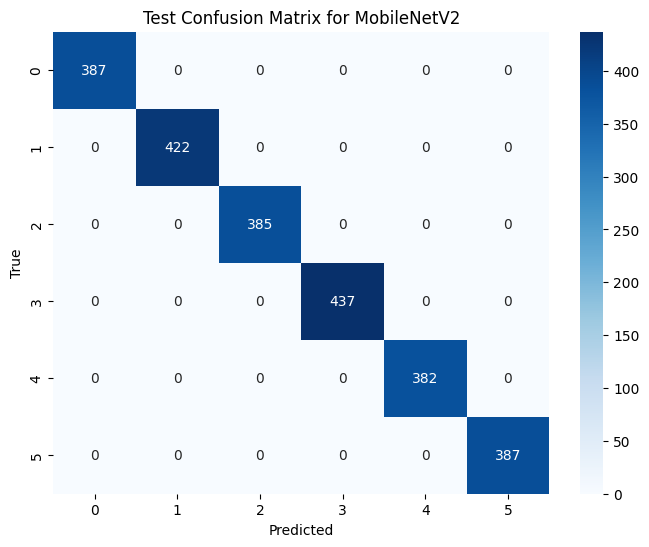


Training EfficientNet-B0...
Epoch 1/15, Loss: 0.3380, Train Acc: 0.9970, Val Acc: 0.9962, Time: 72.19s
Epoch 2/15, Loss: 0.0732, Train Acc: 0.9982, Val Acc: 0.9975, Time: 72.44s
Epoch 3/15, Loss: 0.0460, Train Acc: 0.9985, Val Acc: 0.9975, Time: 71.89s
Epoch 4/15, Loss: 0.0346, Train Acc: 0.9984, Val Acc: 0.9979, Time: 72.36s
Epoch 5/15, Loss: 0.0255, Train Acc: 0.9989, Val Acc: 0.9983, Time: 71.85s
Epoch 6/15, Loss: 0.0234, Train Acc: 0.9988, Val Acc: 0.9992, Time: 73.55s
Epoch 7/15, Loss: 0.0187, Train Acc: 0.9985, Val Acc: 0.9983, Time: 72.73s
Epoch 8/15, Loss: 0.0188, Train Acc: 0.9994, Val Acc: 0.9988, Time: 73.42s
Epoch 9/15, Loss: 0.0139, Train Acc: 0.9991, Val Acc: 0.9983, Time: 72.40s
Early stopping triggered
Total training time: 653.15s
  Final Training Accuracy: 0.9991
  Highest Training Accuracy: 0.9994

Test Metrics for EfficientNet-B0:
  Accuracy: 0.9992, Precision: 0.9992, Recall: 0.9992, F1-Score: 0.9992


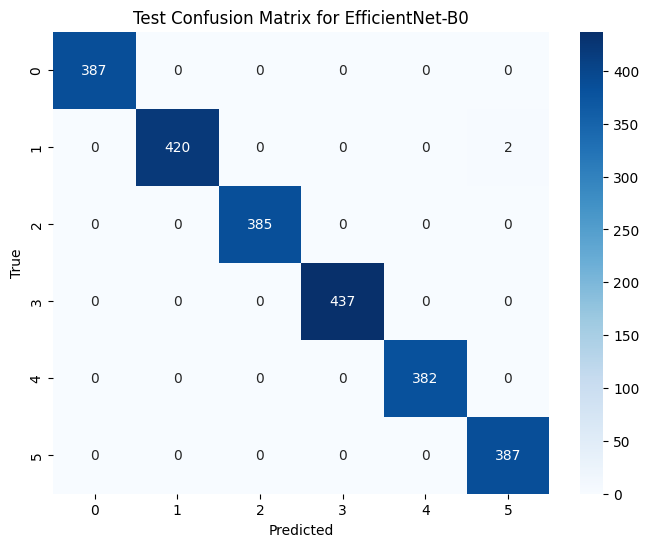


Training DenseNet-121...
Epoch 1/15, Loss: 0.2730, Train Acc: 0.9986, Val Acc: 0.9979, Time: 76.61s
Epoch 2/15, Loss: 0.0441, Train Acc: 0.9997, Val Acc: 0.9992, Time: 77.42s
Epoch 3/15, Loss: 0.0224, Train Acc: 0.9998, Val Acc: 1.0000, Time: 76.73s
Epoch 4/15, Loss: 0.0159, Train Acc: 0.9999, Val Acc: 1.0000, Time: 77.57s
Epoch 5/15, Loss: 0.0114, Train Acc: 0.9999, Val Acc: 1.0000, Time: 75.49s
Epoch 6/15, Loss: 0.0092, Train Acc: 1.0000, Val Acc: 1.0000, Time: 78.50s
Early stopping triggered
Total training time: 462.67s
  Final Training Accuracy: 1.0000
  Highest Training Accuracy: 1.0000

Test Metrics for DenseNet-121:
  Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


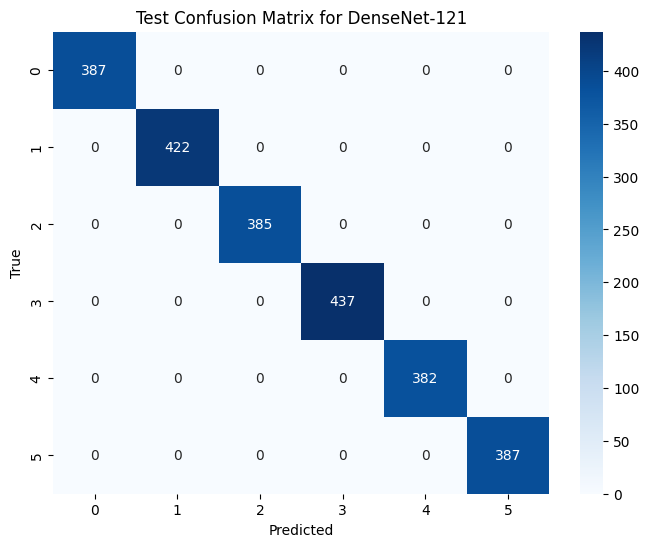

In [13]:
# Train and evaluate 
results = {}
all_train_losses = {}
all_val_losses = {}
all_train_accs = {}
all_val_accs = {}

model_names = []
train_accs_best = []
val_accs_best = []
test_accs = []

for model_name, model in models_dict.items():
    print(f"\nTraining {model_name}...")
    model = modify_model(model, NUM_CLASSES)
    model = freeze_layers(model, model_name)
    model = model.to(device)
    
    # Print model info
    #print_model_info(model, model_name)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    
    # Train
    train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, test_loader, criterion, optimizer, device, PATIENCE)
    all_train_losses[model_name] = train_losses
    all_val_losses[model_name] = val_losses
    all_train_accs[model_name] = train_accs
    all_val_accs[model_name] = val_accs



    # Print training accuracy summary (highest and final)
    final_train_acc = train_accs[-1] if train_accs else 0.0
    highest_train_acc = max(train_accs) if train_accs else 0.0
    print(f"  Final Training Accuracy: {final_train_acc:.4f}")
    print(f"  Highest Training Accuracy: {highest_train_acc:.4f}")


    # Find the best epoch based on validation accuracy
    best_epoch = np.argmax(all_val_accs[model_name])
    train_acc_best = all_train_accs[model_name][best_epoch]
    val_acc_best = all_val_accs[model_name][best_epoch]
    
    
    # Evaluate on test set
    model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pth"))
    test_acc, test_precision, test_recall, test_f1, test_cm = evaluate_model(model, test_loader, device)
    results[model_name] = {
        "Accuracy": test_acc,
        "Precision": test_precision,
        "Recall": test_recall,
        "F1-Score": test_f1,
        "Confusion Matrix": test_cm

    }


    # Store accuracies for bar chart
    model_names.append(model_name)
    train_accs_best.append(train_acc_best)
    val_accs_best.append(val_acc_best)
    test_accs.append(test_acc)

    
    print(f"\nTest Metrics for {model_name}:")
    print(f"  Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")
    
    # Plot confusion matrix with class names
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Test Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    

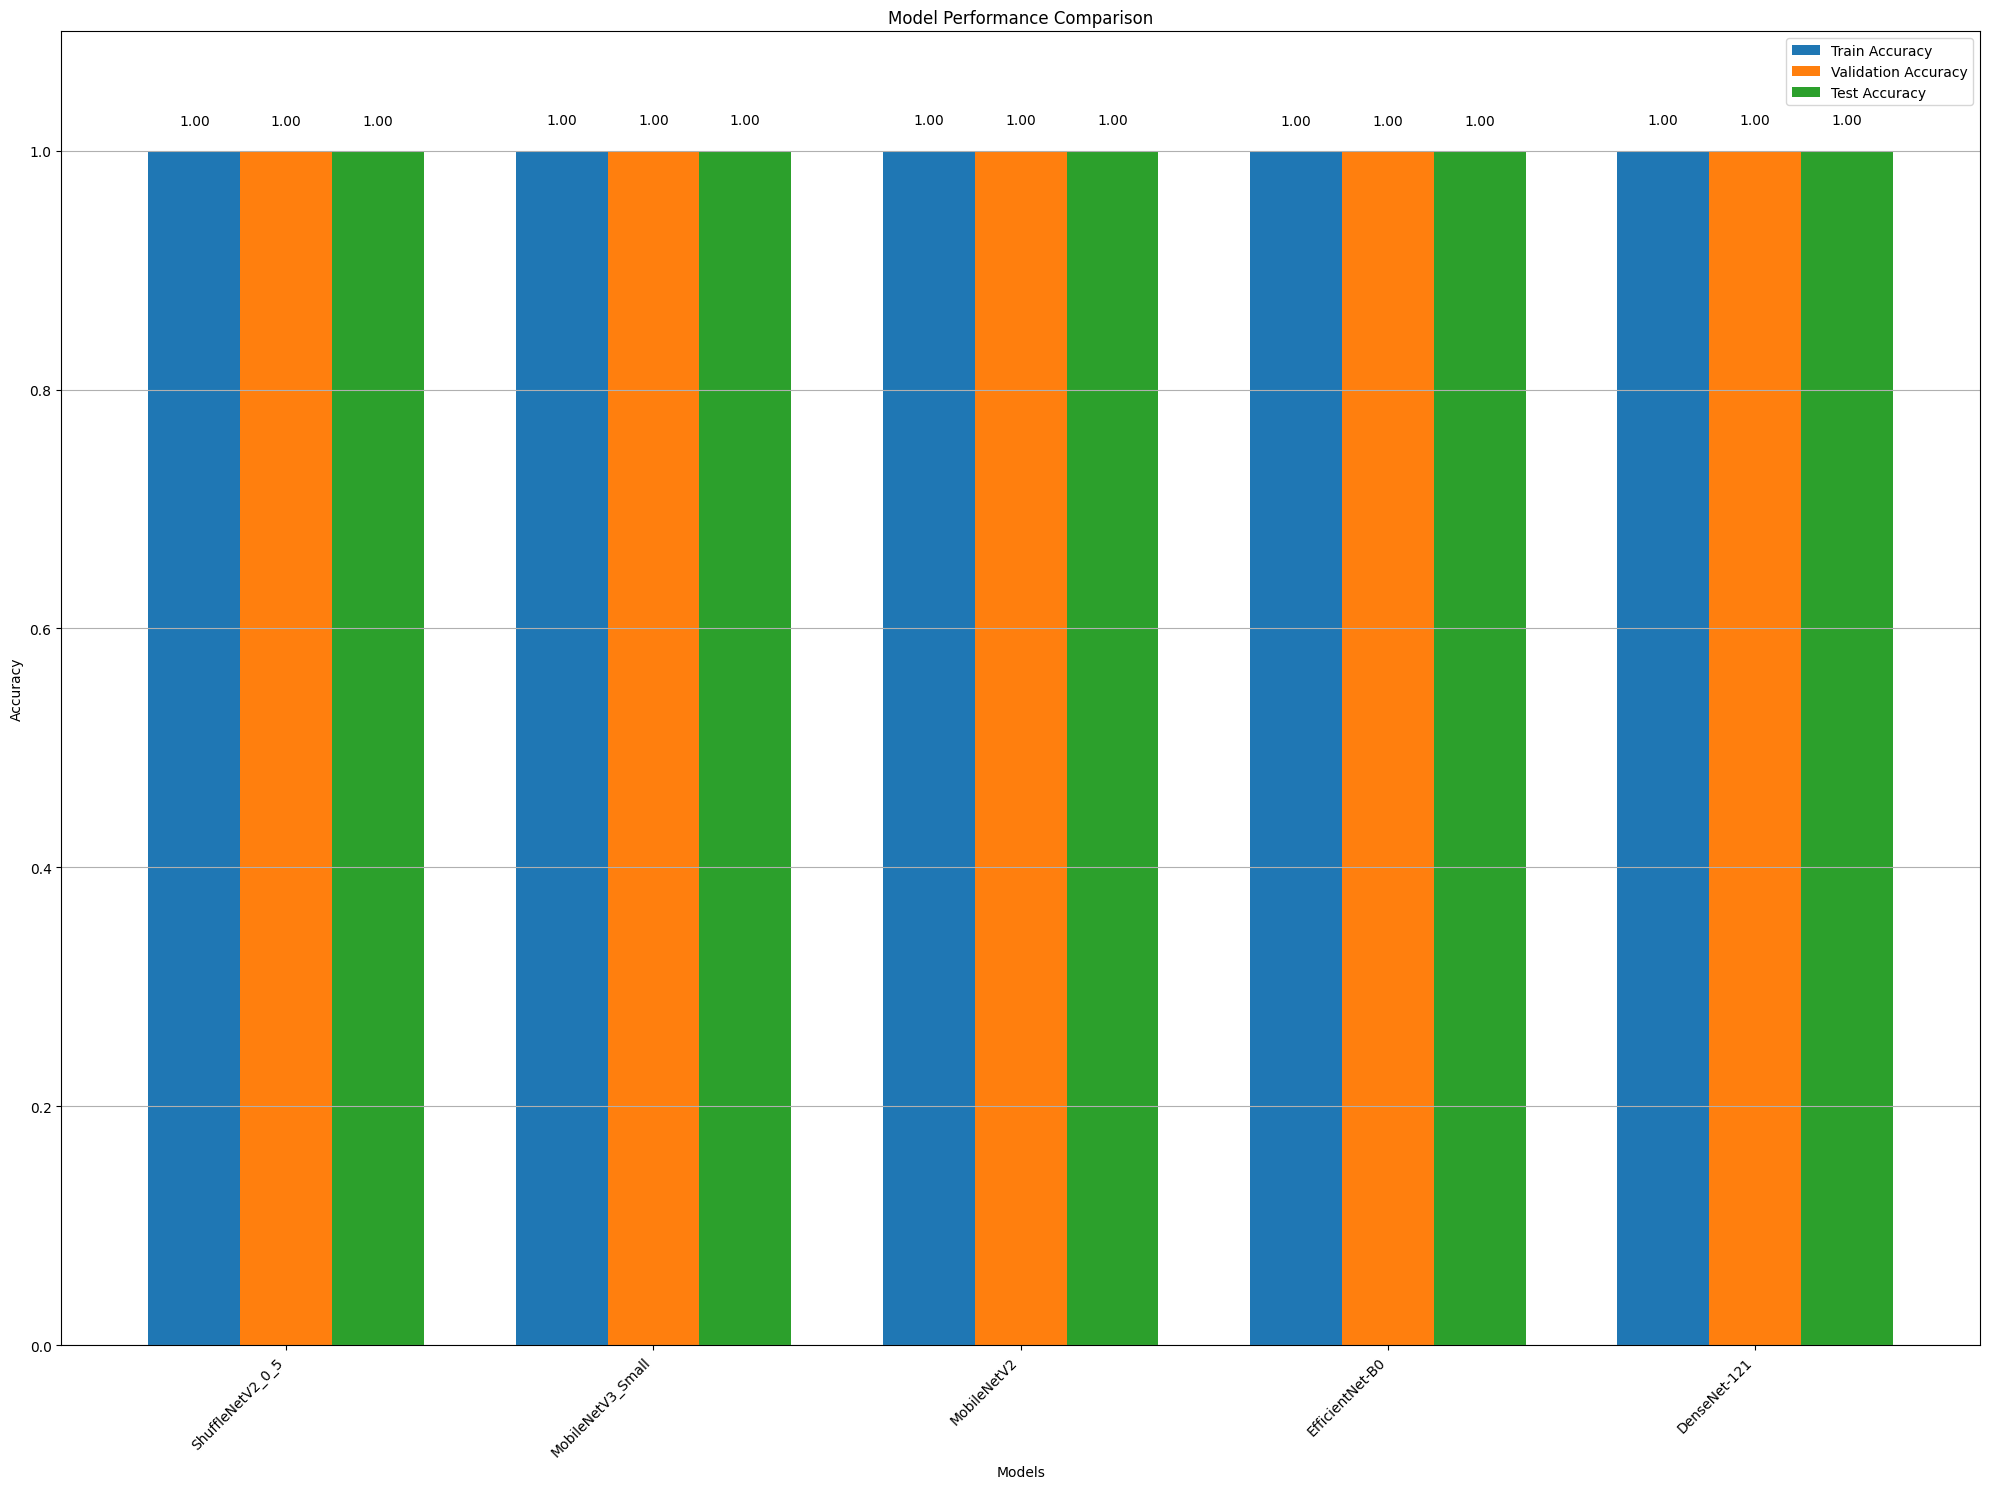

In [14]:
# Create bar chart for training, validation, and test accuracies
N = len(model_names)
ind = np.arange(N)
width = 0.25

fig, ax = plt.subplots(figsize=(20, 15))

# Plot bars and store bar objects
train_bars = ax.bar(ind - width, train_accs_best, width, label='Train Accuracy')
val_bars = ax.bar(ind, val_accs_best, width, label='Validation Accuracy')
test_bars = ax.bar(ind + width, test_accs, width, label='Test Accuracy')

# Function to add text labels above bars
def add_labels(bars, accuracies):
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{acc:.2f}', 
                ha='center', va='bottom')

# Add labels to each set of bars
add_labels(train_bars, train_accs_best)
add_labels(val_bars, val_accs_best)
add_labels(test_bars, test_accs)

# Customize the chart
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Comparison')
ax.set_xticks(ind)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(0, 1.1)  # Extended y-limit to accommodate labels
ax.grid(True, axis='y')
ax.legend()

plt.tight_layout()
plt.show()

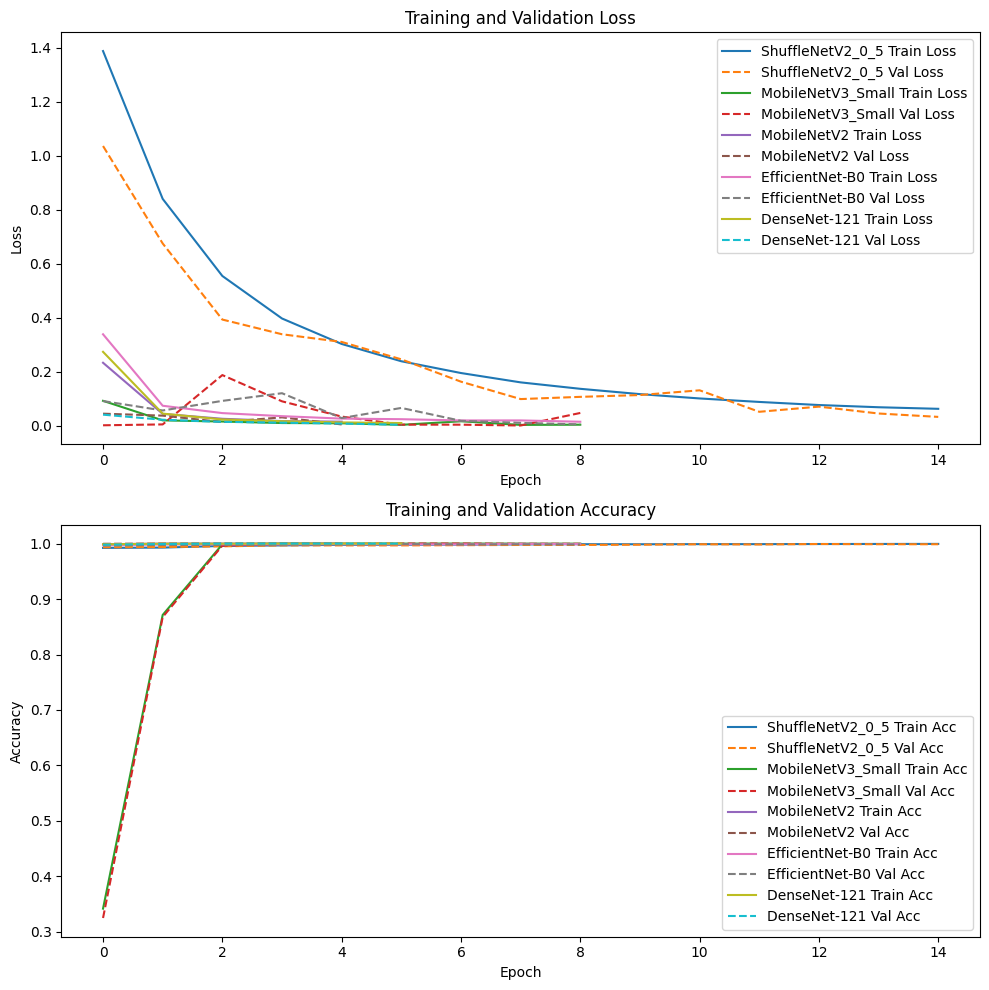

In [15]:
# Plot training and validation loss and accuracy for all models
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for model_name in all_train_losses.keys():
    axes[0].plot(all_train_losses[model_name], label=f"{model_name} Train Loss")
    axes[0].plot(all_val_losses[model_name], label=f"{model_name} Val Loss", linestyle='--')
    axes[1].plot(all_train_accs[model_name], label=f"{model_name} Train Acc")
    axes[1].plot(all_val_accs[model_name], label=f"{model_name} Val Acc", linestyle='--')

axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].set_title("Training and Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

# With Augmentation Techniques

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),          # Resize to 224x224 pixels
    transforms.CenterCrop(IMG_SIZE),                  # Crop to focus on central region
    transforms.Grayscale(num_output_channels=3),      # Convert to grayscale, keep 3 channels
    transforms.RandomHorizontalFlip(),                # Data augmentation
    transforms.RandomRotation(15),                    # Data augmentation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Data augmentation
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),          # Resize to 224x224 pixels
    transforms.CenterCrop(IMG_SIZE),                  # Crop to focus on central region
    transforms.Grayscale(num_output_channels=3),      # Convert to grayscale, keep 3 channels
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [9]:
# Load dataset
dataset = datasets.ImageFolder(root=DATASET_PATH, transform=train_transform)
class_names = dataset.classes  # Get class names from folder names
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
test_dataset.dataset.transform = test_transform

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


Training ShuffleNetV2_0_5...
Epoch 1/15, Loss: 1.3851, Train Acc: 0.9896, Val Acc: 0.9900, Time: 103.86s
Epoch 2/15, Loss: 0.8399, Train Acc: 0.9934, Val Acc: 0.9946, Time: 68.27s
Epoch 3/15, Loss: 0.5554, Train Acc: 0.9952, Val Acc: 0.9967, Time: 72.13s
Epoch 4/15, Loss: 0.3983, Train Acc: 0.9966, Val Acc: 0.9975, Time: 71.19s
Epoch 5/15, Loss: 0.3026, Train Acc: 0.9974, Val Acc: 0.9975, Time: 68.86s
Epoch 6/15, Loss: 0.2396, Train Acc: 0.9980, Val Acc: 0.9979, Time: 68.85s
Epoch 7/15, Loss: 0.1943, Train Acc: 0.9983, Val Acc: 0.9983, Time: 70.47s
Epoch 8/15, Loss: 0.1616, Train Acc: 0.9984, Val Acc: 0.9983, Time: 69.65s
Epoch 9/15, Loss: 0.1353, Train Acc: 0.9986, Val Acc: 0.9988, Time: 69.43s
Epoch 10/15, Loss: 0.1159, Train Acc: 0.9988, Val Acc: 0.9979, Time: 68.86s
Epoch 11/15, Loss: 0.1009, Train Acc: 0.9991, Val Acc: 0.9988, Time: 68.86s
Epoch 12/15, Loss: 0.0878, Train Acc: 0.9993, Val Acc: 0.9988, Time: 68.76s
Early stopping triggered
Total training time: 869.39s
  Final Trai

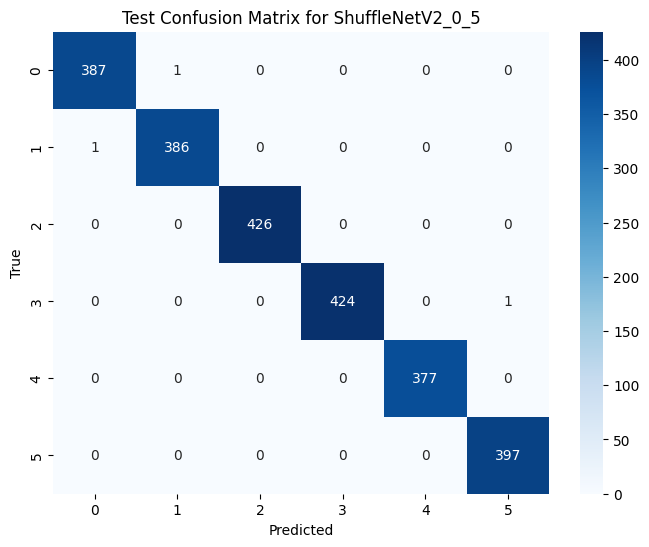


Training MobileNetV3_Small...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15, Loss: 0.1026, Train Acc: 0.4702, Val Acc: 0.4637, Time: 68.82s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/15, Loss: 0.0191, Train Acc: 0.7926, Val Acc: 0.7875, Time: 69.13s
Epoch 3/15, Loss: 0.0234, Train Acc: 0.9981, Val Acc: 0.9975, Time: 68.97s
Epoch 4/15, Loss: 0.0061, Train Acc: 1.0000, Val Acc: 1.0000, Time: 69.56s
Epoch 5/15, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 1.0000, Time: 69.13s
Epoch 6/15, Loss: 0.0061, Train Acc: 1.0000, Val Acc: 1.0000, Time: 70.54s
Epoch 7/15, Loss: 0.0081, Train Acc: 0.9982, Val Acc: 0.9971, Time: 68.17s
Early stopping triggered
Total training time: 484.45s
  Final Training Accuracy: 0.9982
  Highest Training Accuracy: 1.0000

Test Metrics for MobileNetV3_Small:
  Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


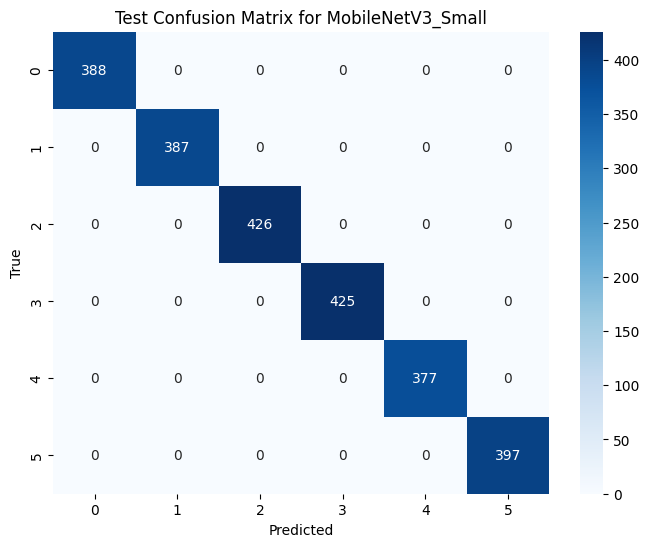


Training MobileNetV2...
Epoch 1/15, Loss: 0.2400, Train Acc: 0.9993, Val Acc: 0.9988, Time: 69.26s
Epoch 2/15, Loss: 0.0419, Train Acc: 0.9997, Val Acc: 1.0000, Time: 71.65s
Epoch 3/15, Loss: 0.0242, Train Acc: 1.0000, Val Acc: 1.0000, Time: 71.10s
Epoch 4/15, Loss: 0.0160, Train Acc: 1.0000, Val Acc: 1.0000, Time: 68.17s
Epoch 5/15, Loss: 0.0115, Train Acc: 1.0000, Val Acc: 1.0000, Time: 71.12s
Early stopping triggered
Total training time: 351.39s
  Final Training Accuracy: 1.0000
  Highest Training Accuracy: 1.0000

Test Metrics for MobileNetV2:
  Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


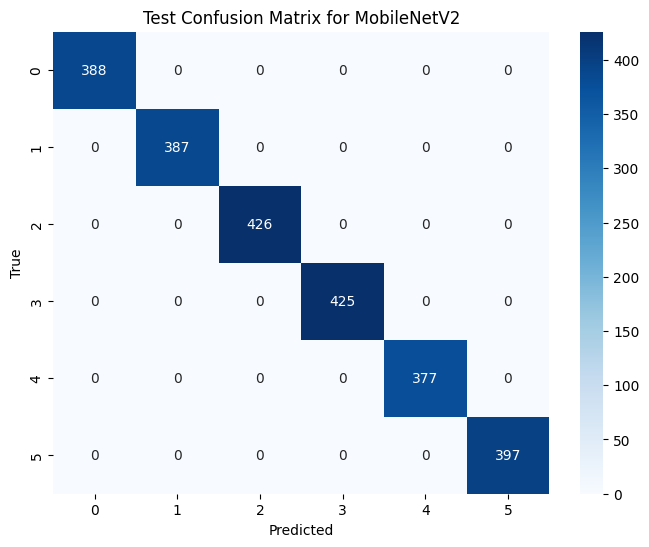


Training EfficientNet-B0...
Epoch 1/15, Loss: 0.3253, Train Acc: 0.9976, Val Acc: 0.9988, Time: 70.91s
Epoch 2/15, Loss: 0.0736, Train Acc: 0.9976, Val Acc: 0.9988, Time: 71.34s
Epoch 3/15, Loss: 0.0450, Train Acc: 0.9985, Val Acc: 0.9988, Time: 70.38s
Epoch 4/15, Loss: 0.0328, Train Acc: 0.9984, Val Acc: 0.9988, Time: 71.87s
Early stopping triggered
Total training time: 284.56s
  Final Training Accuracy: 0.9984
  Highest Training Accuracy: 0.9985

Test Metrics for EfficientNet-B0:
  Accuracy: 0.9988, Precision: 0.9988, Recall: 0.9988, F1-Score: 0.9987


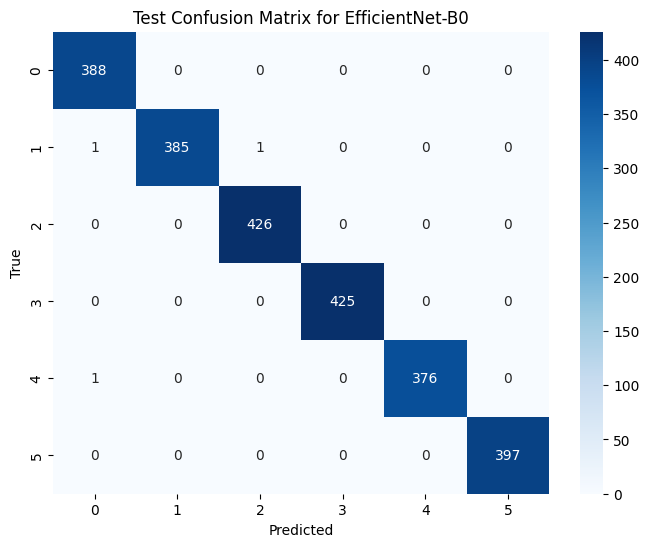


Training DenseNet-121...
Epoch 1/15, Loss: 0.2951, Train Acc: 0.9991, Val Acc: 0.9992, Time: 76.16s
Epoch 2/15, Loss: 0.0468, Train Acc: 0.9994, Val Acc: 0.9988, Time: 77.69s
Epoch 3/15, Loss: 0.0253, Train Acc: 0.9997, Val Acc: 1.0000, Time: 75.95s
Epoch 4/15, Loss: 0.0169, Train Acc: 0.9999, Val Acc: 1.0000, Time: 75.65s
Epoch 5/15, Loss: 0.0124, Train Acc: 0.9999, Val Acc: 1.0000, Time: 74.56s
Epoch 6/15, Loss: 0.0095, Train Acc: 1.0000, Val Acc: 1.0000, Time: 75.11s
Early stopping triggered
Total training time: 455.34s
  Final Training Accuracy: 1.0000
  Highest Training Accuracy: 1.0000

Test Metrics for DenseNet-121:
  Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


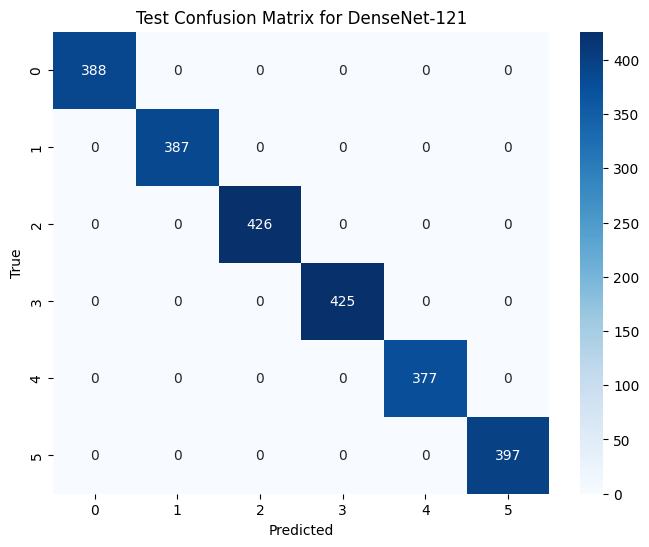

In [19]:
# Train and evaluate
results = {}
all_train_losses = {}
all_val_losses = {}
all_train_accs = {}
all_val_accs = {}

model_names = []
train_accs_best = []
val_accs_best = []
test_accs = []

for model_name, model in models_dict.items():
    print(f"\nTraining {model_name}...")
    model = modify_model(model, NUM_CLASSES)
    model = freeze_layers(model, model_name)
    model = model.to(device)
    
    # Print model info
    #print_model_info(model, model_name)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    
    # Train
    train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, test_loader, criterion, optimizer, device, PATIENCE)
    all_train_losses[model_name] = train_losses
    all_val_losses[model_name] = val_losses
    all_train_accs[model_name] = train_accs
    all_val_accs[model_name] = val_accs



    # Print training accuracy summary (highest and final)
    final_train_acc = train_accs[-1] if train_accs else 0.0
    highest_train_acc = max(train_accs) if train_accs else 0.0
    print(f"  Final Training Accuracy: {final_train_acc:.4f}")
    print(f"  Highest Training Accuracy: {highest_train_acc:.4f}")


    # Find the best epoch based on validation accuracy
    best_epoch = np.argmax(all_val_accs[model_name])
    train_acc_best = all_train_accs[model_name][best_epoch]
    val_acc_best = all_val_accs[model_name][best_epoch]
    
    
    # Evaluate on test set
    model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pth"))
    test_acc, test_precision, test_recall, test_f1, test_cm = evaluate_model(model, test_loader, device)
    results[model_name] = {
        "Accuracy": test_acc,
        "Precision": test_precision,
        "Recall": test_recall,
        "F1-Score": test_f1,
        "Confusion Matrix": test_cm

    }


    # Store accuracies for bar chart
    model_names.append(model_name)
    train_accs_best.append(train_acc_best)
    val_accs_best.append(val_acc_best)
    test_accs.append(test_acc)

    
    print(f"\nTest Metrics for {model_name}:")
    print(f"  Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")
    
    # Plot confusion matrix with class names
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Test Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    

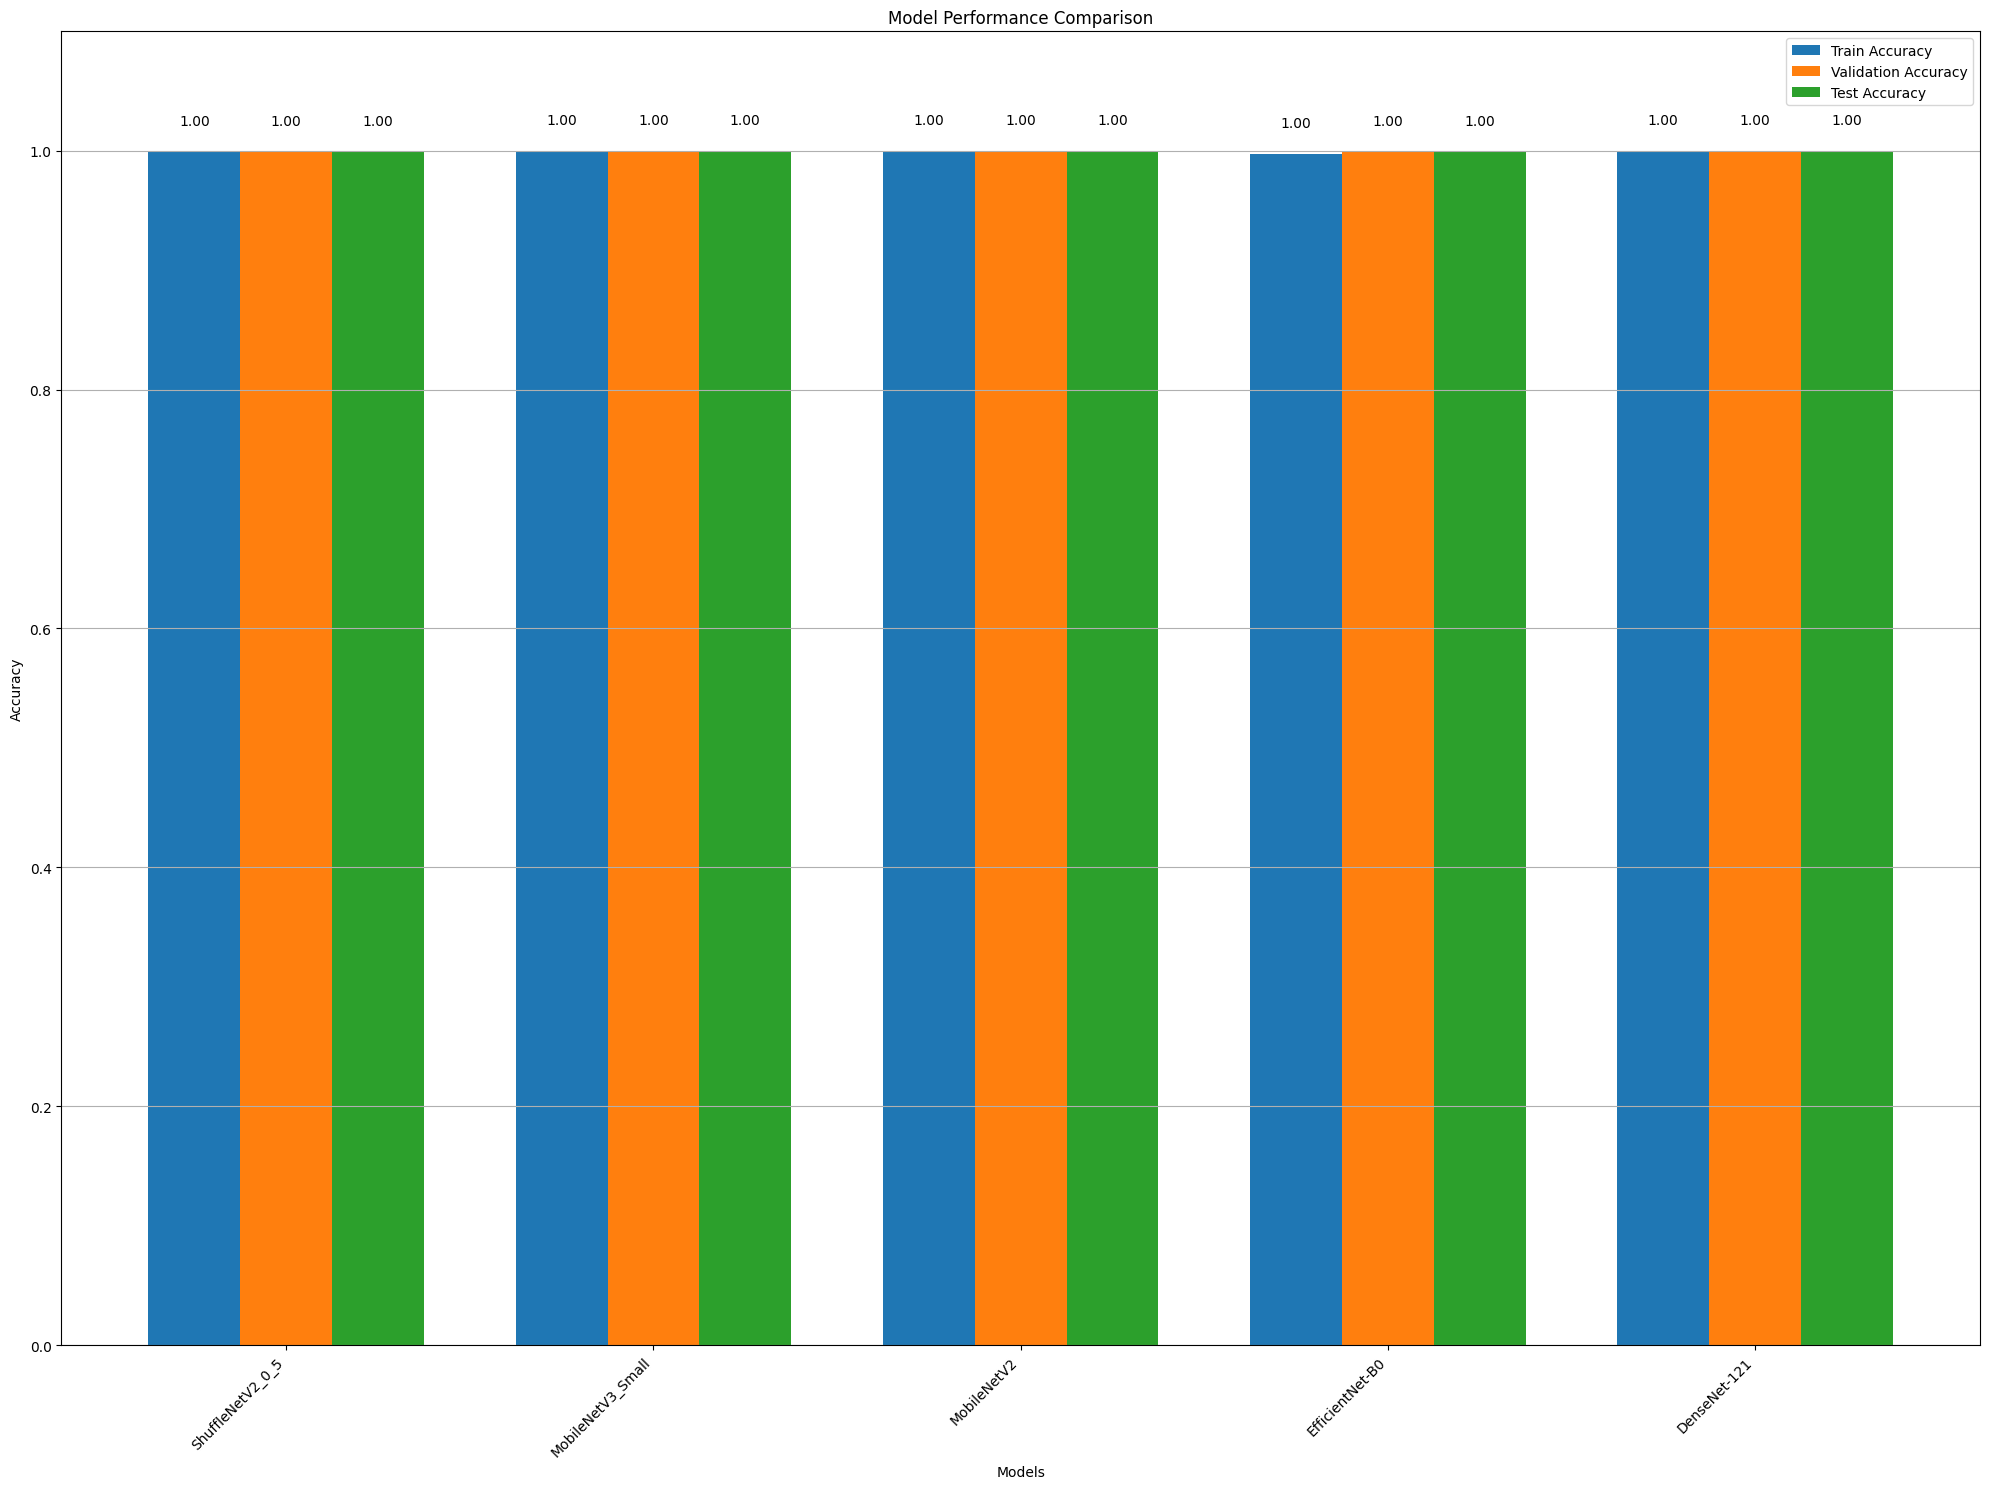

In [20]:
# Create bar chart for training, validation, and test accuracies
N = len(model_names)
ind = np.arange(N)
width = 0.25

fig, ax = plt.subplots(figsize=(20, 15))

# Plot bars and store bar objects
train_bars = ax.bar(ind - width, train_accs_best, width, label='Train Accuracy')
val_bars = ax.bar(ind, val_accs_best, width, label='Validation Accuracy')
test_bars = ax.bar(ind + width, test_accs, width, label='Test Accuracy')

# Function to add text labels above bars
def add_labels(bars, accuracies):
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{acc:.2f}', 
                ha='center', va='bottom')

# Add labels to each set of bars
add_labels(train_bars, train_accs_best)
add_labels(val_bars, val_accs_best)
add_labels(test_bars, test_accs)

# Customize the chart
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Comparison')
ax.set_xticks(ind)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(0, 1.1)  # Extended y-limit to accommodate labels
ax.grid(True, axis='y')
ax.legend()

plt.tight_layout()
plt.show()

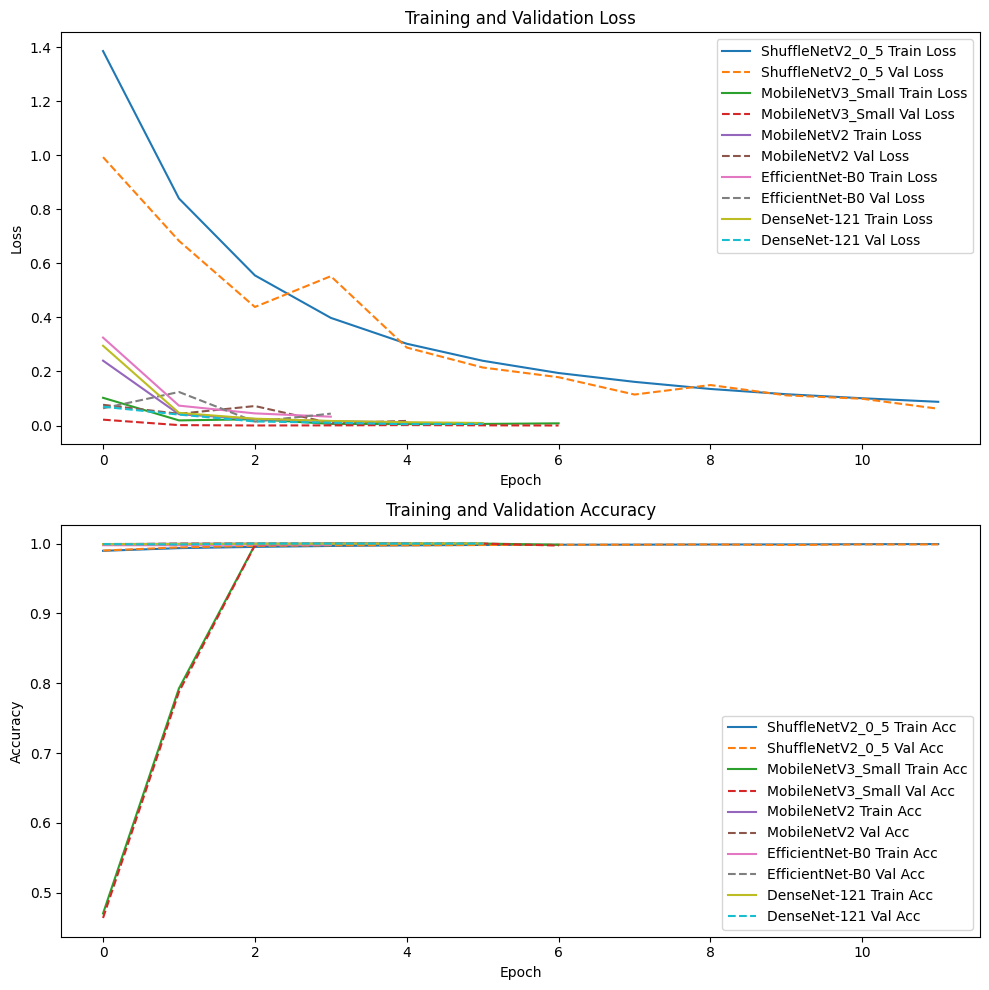

In [21]:
# Plot training and validation loss and accuracy for all models
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for model_name in all_train_losses.keys():
    axes[0].plot(all_train_losses[model_name], label=f"{model_name} Train Loss")
    axes[0].plot(all_val_losses[model_name], label=f"{model_name} Val Loss", linestyle='--')
    axes[1].plot(all_train_accs[model_name], label=f"{model_name} Train Acc")
    axes[1].plot(all_val_accs[model_name], label=f"{model_name} Val Acc", linestyle='--')

axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].set_title("Training and Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

# Try the Kaggle Datasets With the Same Models

**With Augmentation**

In [17]:
# Define dataset paths and parameters
DATASET_PATH = "/kaggle/input/leapgestrecog/leapGestRecog/00/"  # Update to your dataset path in Colab
NUM_CLASSES = 10


In [18]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),          # Resize to 224x224 pixels
    transforms.CenterCrop(IMG_SIZE),                  # Crop to focus on central region
    transforms.Grayscale(num_output_channels=3),      # Convert to grayscale, keep 3 channels
    transforms.RandomHorizontalFlip(),                # Data augmentation
    transforms.RandomRotation(15),                    # Data augmentation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Data augmentation
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),          # Resize to 224x224 pixels
    transforms.CenterCrop(IMG_SIZE),                  # Crop to focus on central region
    transforms.Grayscale(num_output_channels=3),      # Convert to grayscale, keep 3 channels
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [19]:
# Load dataset
dataset = datasets.ImageFolder(root=DATASET_PATH, transform=train_transform)
class_names = dataset.classes  # Get class names from folder names
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
test_dataset.dataset.transform = test_transform

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [20]:
####### Modify final layer

def modify_model(model, num_classes):
    if isinstance(model, models.resnet.ResNet):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif isinstance(model, models.mobilenet.MobileNetV2):
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif isinstance(model, models.efficientnet.EfficientNet):
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif isinstance(model, models.densenet.DenseNet):
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif "vit" in model.__class__.__name__.lower():
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    elif isinstance(model, models.shufflenetv2.ShuffleNetV2):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif isinstance(model, models.squeezenet.SqueezeNet):
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model.num_classes = num_classes
    elif isinstance(model, models.mobilenet.MobileNetV3):
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    elif "tinynet" in model.__class__.__name__.lower():
        model.head = nn.Linear(model.head.in_features, num_classes)
    elif "lcnet" in model.__class__.__name__.lower():
        model.head = nn.Linear(model.head.in_features, num_classes)
    elif "hardcorenas" in model.__class__.__name__.lower():
        model.head = nn.Linear(model.head.in_features, num_classes)
    
    return model

In [21]:
for model_name, model in models_dict.items():
    model = modify_model(model, NUM_CLASSES)
    model = freeze_layers(model, model_name)
    model = model.to(device)
    
    # Print model info
    print_model_info(model, model_name)


ShuffleNetV2_0_5:
  Total parameters: 352,042
  Trainable parameters: 10,250
  Non-trainable parameters: 341,792
  Model size: 1.48 MB

MobileNetV3_Small:
  Total parameters: 1,528,106
  Trainable parameters: 601,098
  Non-trainable parameters: 927,008
  Model size: 5.96 MB

MobileNetV2:
  Total parameters: 2,236,682
  Trainable parameters: 12,810
  Non-trainable parameters: 2,223,872
  Model size: 8.77 MB

EfficientNet-B0:
  Total parameters: 4,020,358
  Trainable parameters: 12,810
  Non-trainable parameters: 4,007,548
  Model size: 15.63 MB

DenseNet-121:
  Total parameters: 6,964,106
  Trainable parameters: 10,250
  Non-trainable parameters: 6,953,856
  Model size: 27.15 MB



Training ShuffleNetV2_0_5...
Epoch 1/15, Loss: 2.2048, Train Acc: 0.8819, Val Acc: 0.8650, Time: 17.47s
Epoch 2/15, Loss: 2.0086, Train Acc: 0.9906, Val Acc: 0.9850, Time: 10.56s
Epoch 3/15, Loss: 1.8293, Train Acc: 0.9912, Val Acc: 0.9850, Time: 10.81s
Epoch 4/15, Loss: 1.6611, Train Acc: 0.9925, Val Acc: 0.9875, Time: 11.02s
Epoch 5/15, Loss: 1.5084, Train Acc: 0.9925, Val Acc: 0.9850, Time: 10.86s
Epoch 6/15, Loss: 1.3656, Train Acc: 0.9906, Val Acc: 0.9875, Time: 11.16s
Epoch 7/15, Loss: 1.2383, Train Acc: 0.9938, Val Acc: 0.9875, Time: 10.50s
Early stopping triggered
Total training time: 82.47s
  Final Training Accuracy: 0.9938
  Highest Training Accuracy: 0.9938

Test Metrics for ShuffleNetV2_0_5:
  Accuracy: 0.9875, Precision: 0.9878, Recall: 0.9875, F1-Score: 0.9874


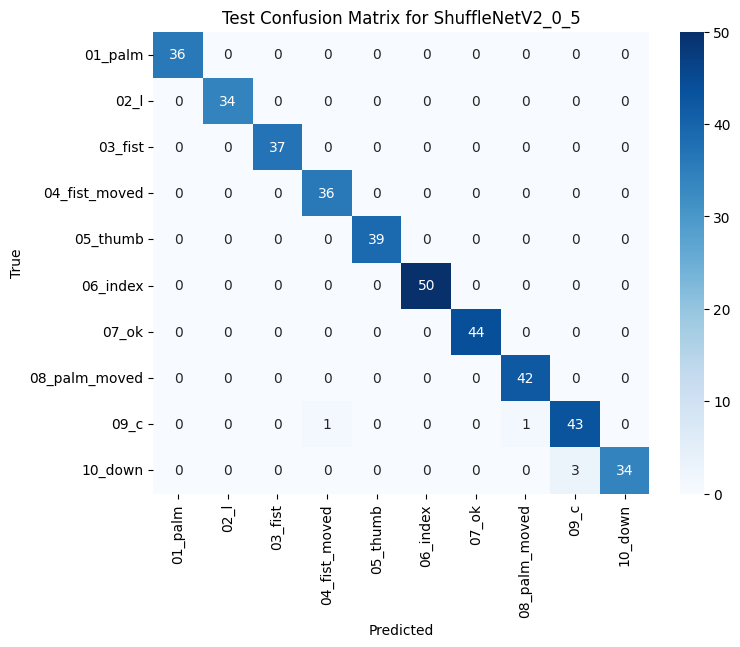


Training MobileNetV3_Small...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15, Loss: 0.4982, Train Acc: 0.6062, Val Acc: 0.5700, Time: 10.27s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/15, Loss: 0.0208, Train Acc: 0.5744, Val Acc: 0.5675, Time: 10.75s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/15, Loss: 0.0091, Train Acc: 0.5262, Val Acc: 0.5150, Time: 10.52s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/15, Loss: 0.0096, Train Acc: 0.6156, Val Acc: 0.5800, Time: 10.32s
Epoch 5/15, Loss: 0.0057, Train Acc: 0.6856, Val Acc: 0.6400, Time: 10.98s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/15, Loss: 0.0035, Train Acc: 0.7344, Val Acc: 0.7000, Time: 10.43s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/15, Loss: 0.0018, Train Acc: 0.8000, Val Acc: 0.7725, Time: 10.51s
Epoch 8/15, Loss: 0.0013, Train Acc: 0.8725, Val Acc: 0.8475, Time: 10.81s
Epoch 9/15, Loss: 0.0020, Train Acc: 0.9675, Val Acc: 0.9550, Time: 10.54s
Epoch 10/15, Loss: 0.0014, Train Acc: 0.9869, Val Acc: 0.9725, Time: 10.95s
Epoch 11/15, Loss: 0.0010, Train Acc: 0.9862, Val Acc: 0.9700, Time: 10.70s
Epoch 12/15, Loss: 0.0006, Train Acc: 0.9962, Val Acc: 0.9775, Time: 10.47s
Epoch 13/15, Loss: 0.0005, Train Acc: 0.9981, Val Acc: 0.9850, Time: 10.68s
Epoch 14/15, Loss: 0.0004, Train Acc: 0.9975, Val Acc: 0.9800, Time: 11.35s
Epoch 15/15, Loss: 0.0005, Train Acc: 0.9981, Val Acc: 0.9800, Time: 10.50s
Total training time: 160.09s
  Final Training Accuracy: 0.9981
  Highest Training Accuracy: 0.9981

Test Metrics for MobileNetV3_Small:
  Accuracy: 0.9850, Precision: 0.9859, Recall: 0.9850, F1-Score: 0.9849


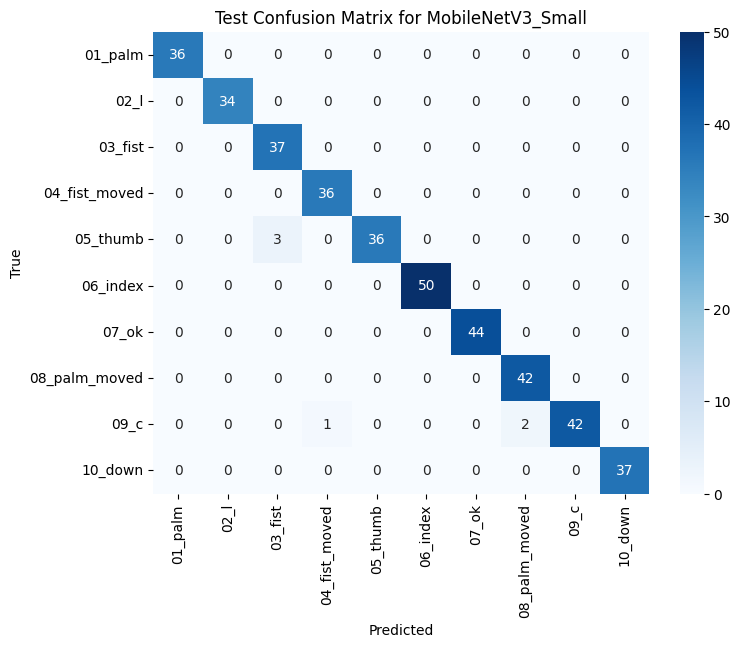


Training MobileNetV2...
Epoch 1/15, Loss: 0.8777, Train Acc: 0.9925, Val Acc: 0.9875, Time: 10.56s
Epoch 2/15, Loss: 0.1491, Train Acc: 0.9981, Val Acc: 0.9925, Time: 10.93s
Epoch 3/15, Loss: 0.0734, Train Acc: 0.9994, Val Acc: 1.0000, Time: 10.62s
Epoch 4/15, Loss: 0.0494, Train Acc: 1.0000, Val Acc: 1.0000, Time: 10.79s
Epoch 5/15, Loss: 0.0368, Train Acc: 0.9994, Val Acc: 0.9975, Time: 11.12s
Epoch 6/15, Loss: 0.0286, Train Acc: 0.9994, Val Acc: 1.0000, Time: 10.63s
Early stopping triggered
Total training time: 64.79s
  Final Training Accuracy: 0.9994
  Highest Training Accuracy: 1.0000

Test Metrics for MobileNetV2:
  Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


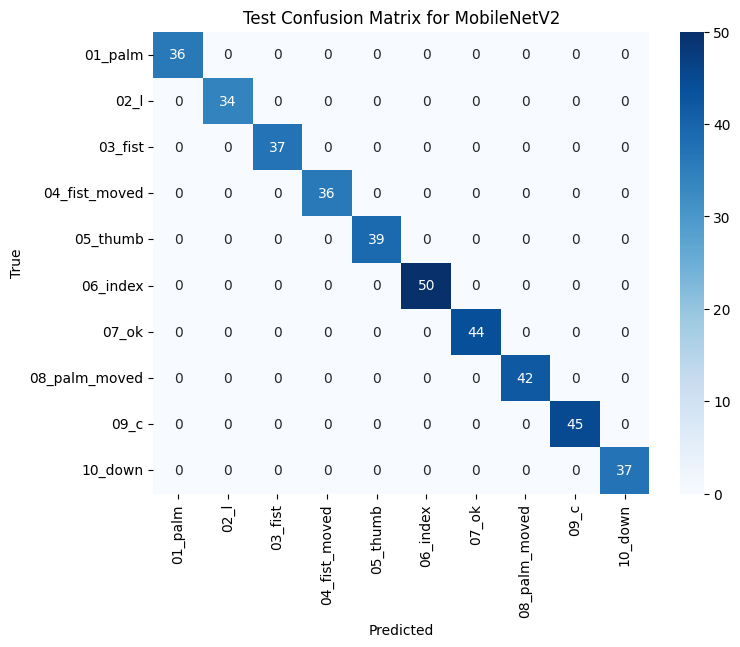


Training EfficientNet-B0...
Epoch 1/15, Loss: 1.2375, Train Acc: 0.9875, Val Acc: 0.9850, Time: 10.92s
Epoch 2/15, Loss: 0.3480, Train Acc: 0.9981, Val Acc: 0.9950, Time: 10.73s
Epoch 3/15, Loss: 0.1898, Train Acc: 0.9988, Val Acc: 0.9975, Time: 11.57s
Epoch 4/15, Loss: 0.1395, Train Acc: 0.9988, Val Acc: 0.9975, Time: 11.10s
Epoch 5/15, Loss: 0.1038, Train Acc: 0.9994, Val Acc: 0.9975, Time: 10.80s
Epoch 6/15, Loss: 0.0840, Train Acc: 0.9994, Val Acc: 0.9975, Time: 10.96s
Early stopping triggered
Total training time: 66.25s
  Final Training Accuracy: 0.9994
  Highest Training Accuracy: 0.9994

Test Metrics for EfficientNet-B0:
  Accuracy: 0.9975, Precision: 0.9976, Recall: 0.9975, F1-Score: 0.9975


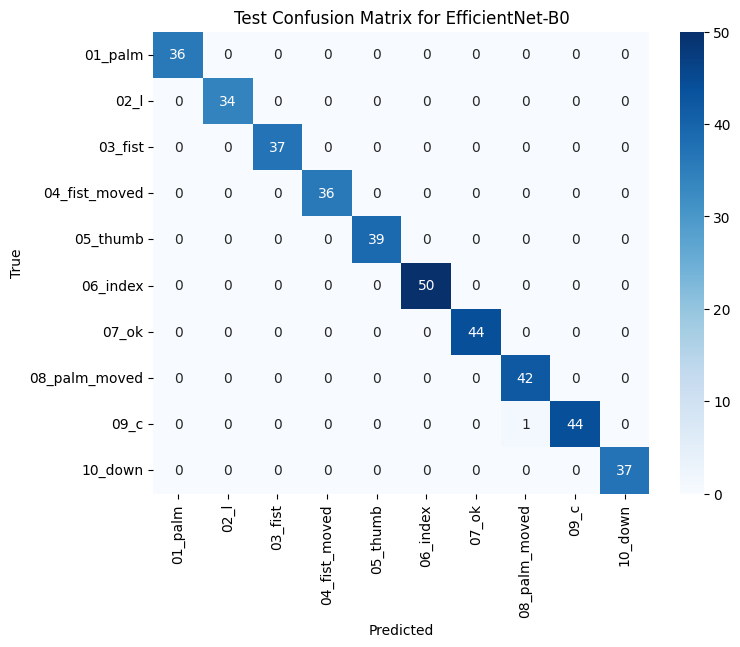


Training DenseNet-121...
Epoch 1/15, Loss: 1.2173, Train Acc: 0.9919, Val Acc: 0.9875, Time: 11.74s
Epoch 2/15, Loss: 0.2826, Train Acc: 0.9975, Val Acc: 0.9875, Time: 11.83s
Epoch 3/15, Loss: 0.1345, Train Acc: 0.9988, Val Acc: 0.9925, Time: 11.89s
Epoch 4/15, Loss: 0.0833, Train Acc: 0.9988, Val Acc: 0.9925, Time: 11.86s
Epoch 5/15, Loss: 0.0644, Train Acc: 0.9994, Val Acc: 0.9950, Time: 11.78s
Epoch 6/15, Loss: 0.0464, Train Acc: 0.9994, Val Acc: 0.9925, Time: 11.92s
Epoch 7/15, Loss: 0.0361, Train Acc: 0.9994, Val Acc: 0.9950, Time: 11.46s
Epoch 8/15, Loss: 0.0306, Train Acc: 0.9994, Val Acc: 0.9925, Time: 11.58s
Early stopping triggered
Total training time: 94.70s
  Final Training Accuracy: 0.9994
  Highest Training Accuracy: 0.9994

Test Metrics for DenseNet-121:
  Accuracy: 0.9950, Precision: 0.9951, Recall: 0.9950, F1-Score: 0.9950


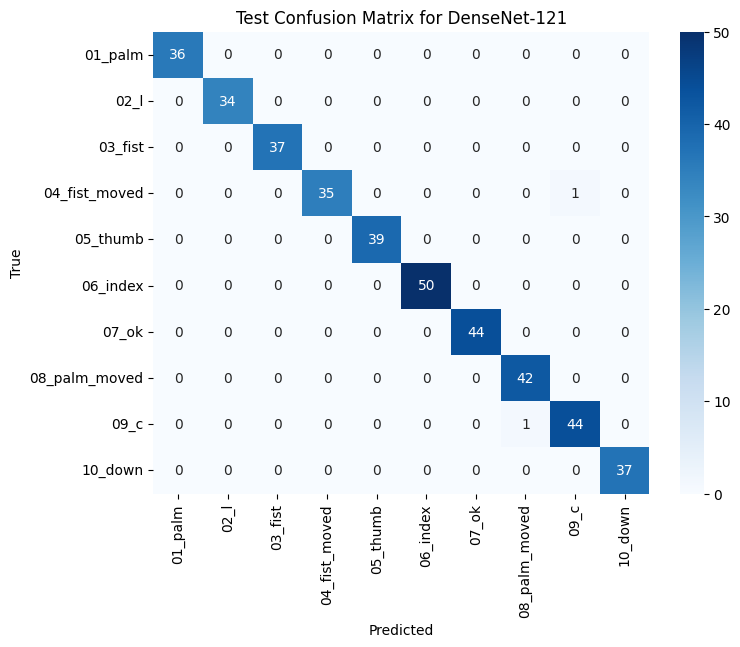

In [22]:
# Train and evaluate
results = {}
all_train_losses = {}
all_val_losses = {}
all_train_accs = {}
all_val_accs = {}

model_names = []
train_accs_best = []
val_accs_best = []
test_accs = []

for model_name, model in models_dict.items():
    print(f"\nTraining {model_name}...")
    model = modify_model(model, NUM_CLASSES)
    model = freeze_layers(model, model_name)
    model = model.to(device)
    
    # Print model info
    #print_model_info(model, model_name)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    
    # Train
    train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, test_loader, criterion, optimizer, device, PATIENCE)
    all_train_losses[model_name] = train_losses
    all_val_losses[model_name] = val_losses
    all_train_accs[model_name] = train_accs
    all_val_accs[model_name] = val_accs



    # Print training accuracy summary (highest and final)
    final_train_acc = train_accs[-1] if train_accs else 0.0
    highest_train_acc = max(train_accs) if train_accs else 0.0
    print(f"  Final Training Accuracy: {final_train_acc:.4f}")
    print(f"  Highest Training Accuracy: {highest_train_acc:.4f}")


    # Find the best epoch based on validation accuracy
    best_epoch = np.argmax(all_val_accs[model_name])
    train_acc_best = all_train_accs[model_name][best_epoch]
    val_acc_best = all_val_accs[model_name][best_epoch]
    
    
    # Evaluate on test set
    model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pth"))
    test_acc, test_precision, test_recall, test_f1, test_cm = evaluate_model(model, test_loader, device)
    results[model_name] = {
        "Accuracy": test_acc,
        "Precision": test_precision,
        "Recall": test_recall,
        "F1-Score": test_f1,
        "Confusion Matrix": test_cm

    }


    # Store accuracies for bar chart
    model_names.append(model_name)
    train_accs_best.append(train_acc_best)
    val_accs_best.append(val_acc_best)
    test_accs.append(test_acc)

    
    print(f"\nTest Metrics for {model_name}:")
    print(f"  Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")
    
    # Plot confusion matrix with class names
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Test Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    

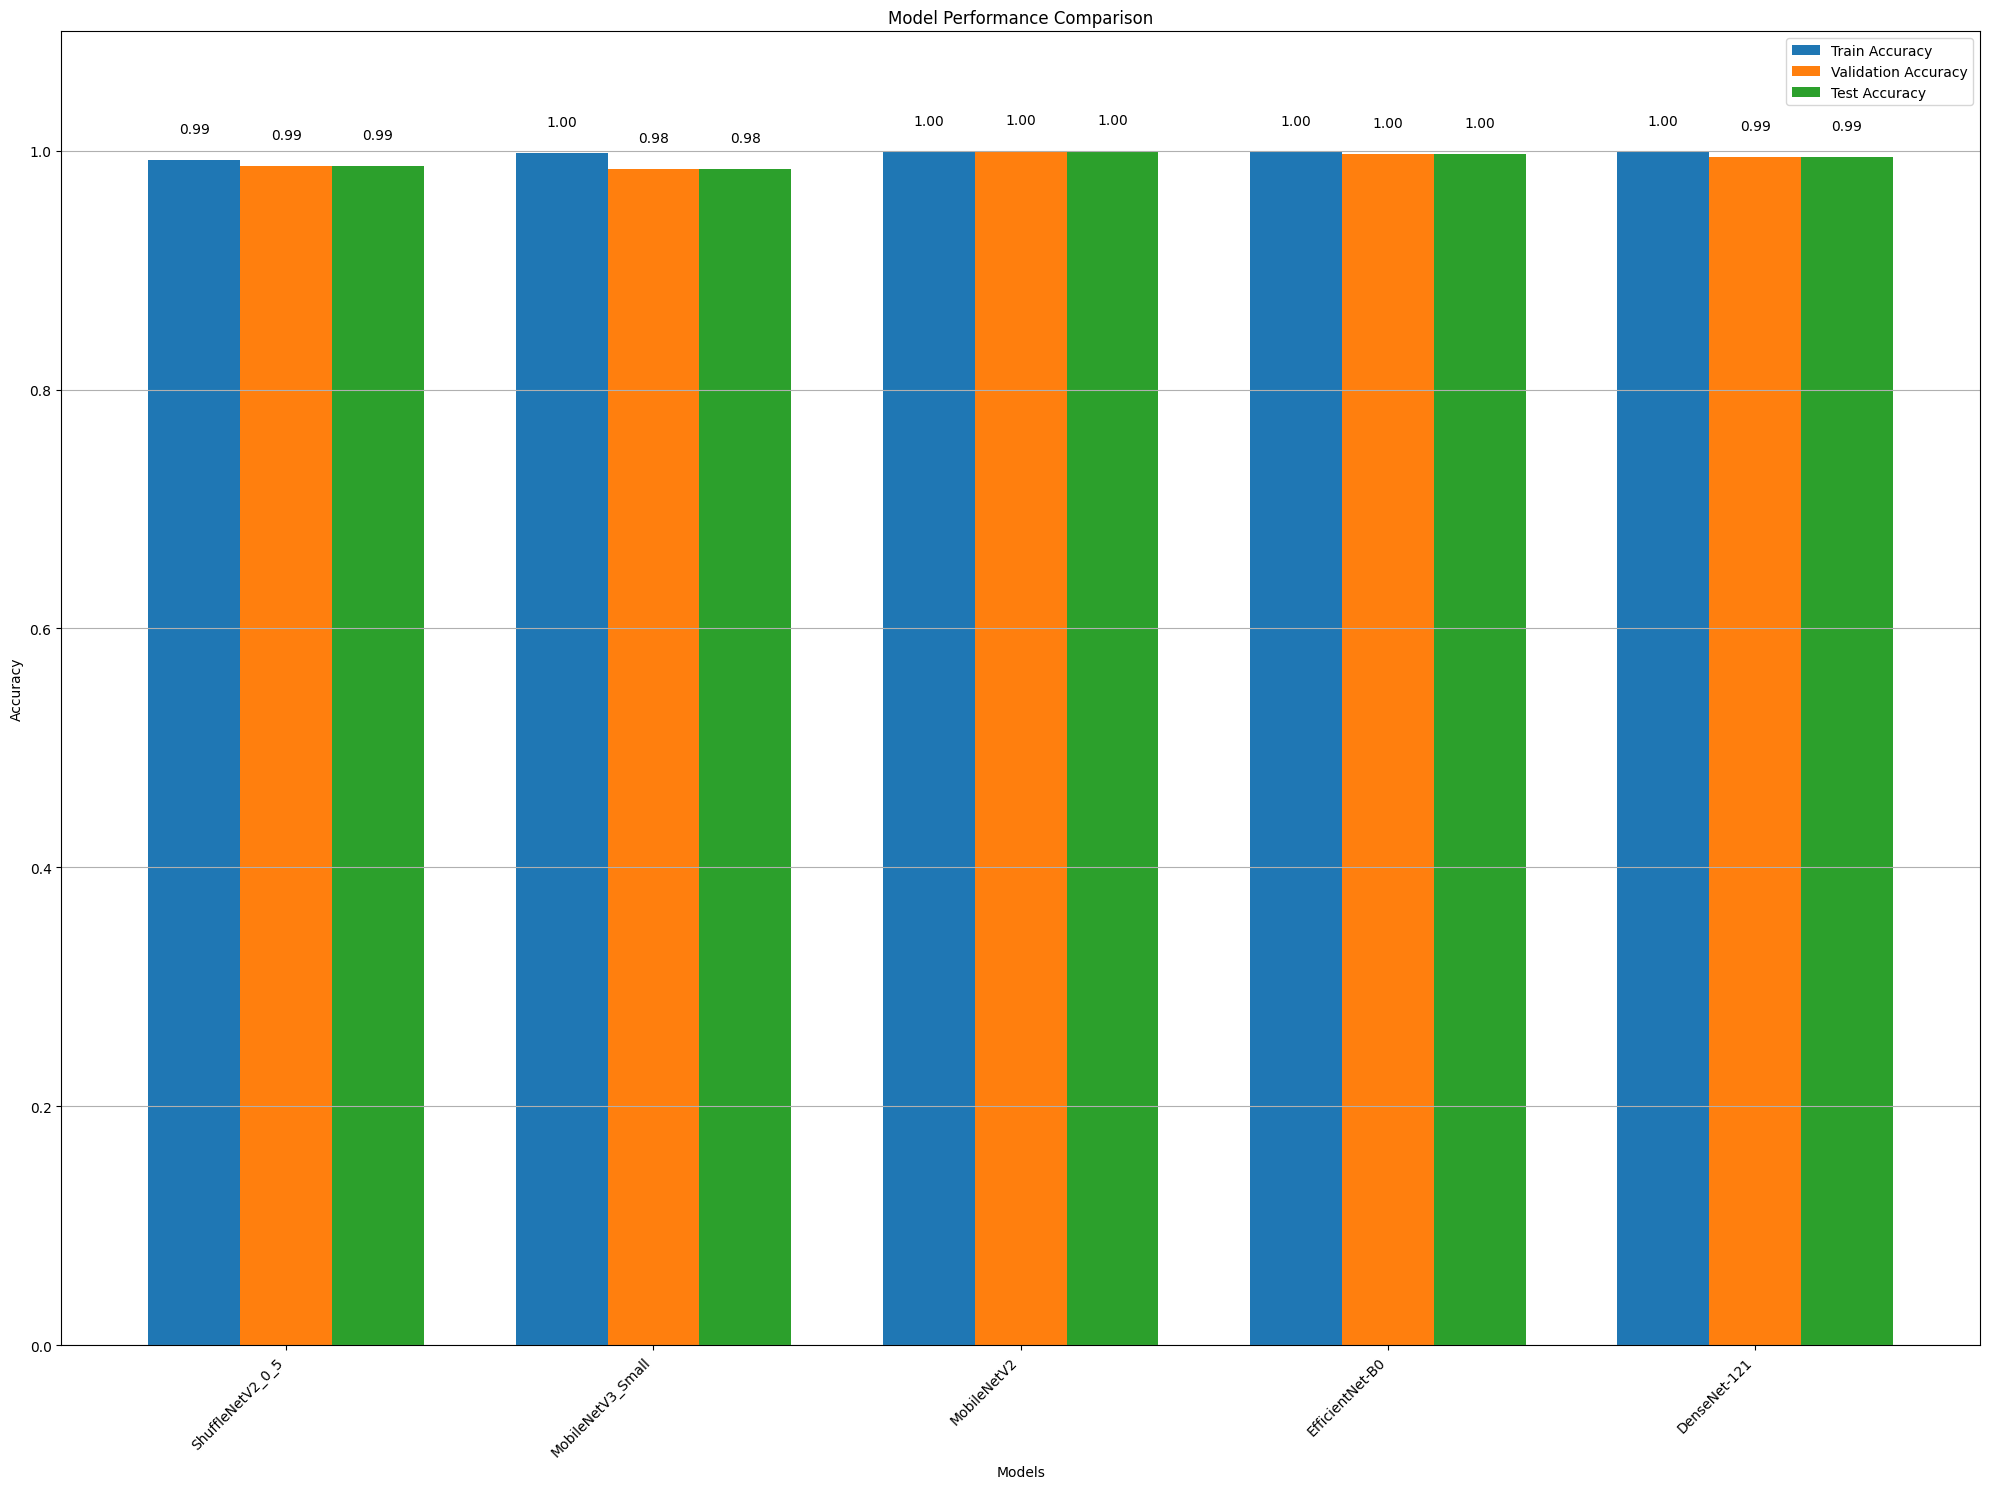

In [23]:
# Create bar chart for training, validation, and test accuracies
N = len(model_names)
ind = np.arange(N)
width = 0.25

fig, ax = plt.subplots(figsize=(20, 15))

# Plot bars and store bar objects
train_bars = ax.bar(ind - width, train_accs_best, width, label='Train Accuracy')
val_bars = ax.bar(ind, val_accs_best, width, label='Validation Accuracy')
test_bars = ax.bar(ind + width, test_accs, width, label='Test Accuracy')

# Function to add text labels above bars
def add_labels(bars, accuracies):
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{acc:.2f}', 
                ha='center', va='bottom')

# Add labels to each set of bars
add_labels(train_bars, train_accs_best)
add_labels(val_bars, val_accs_best)
add_labels(test_bars, test_accs)

# Customize the chart
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Comparison')
ax.set_xticks(ind)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(0, 1.1)  # Extended y-limit to accommodate labels
ax.grid(True, axis='y')
ax.legend()

plt.tight_layout()
plt.show()

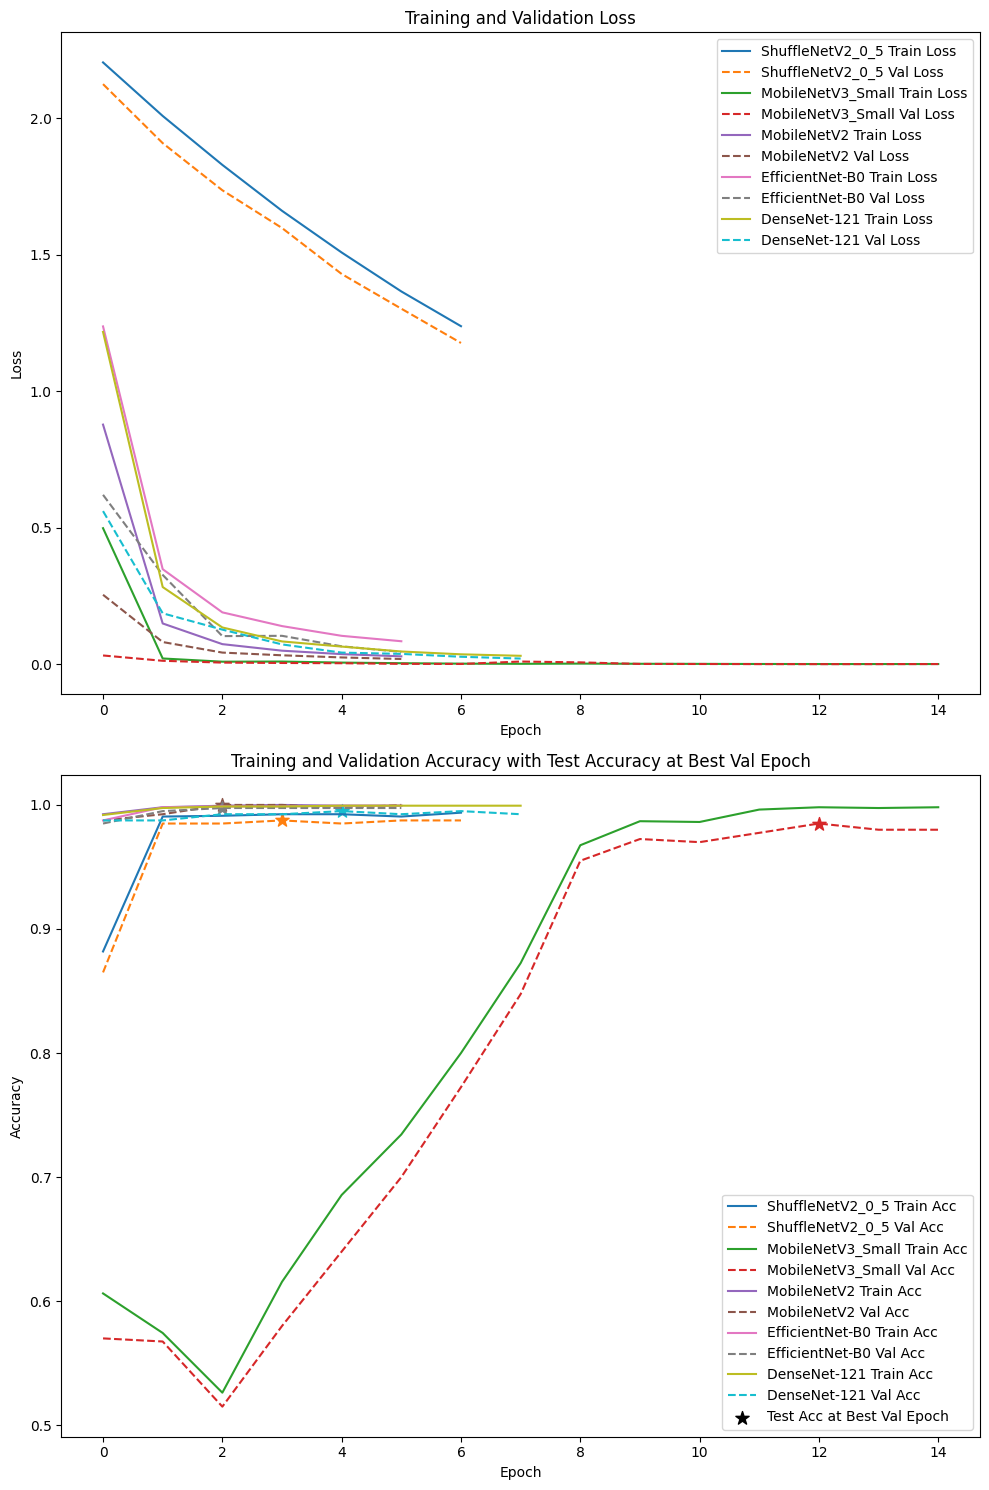

In [24]:

# Plot training and validation loss and accuracy for all models
fig, axes = plt.subplots(2, 1, figsize=(10, 15))
for model_name in all_train_losses.keys():
    # Loss plot (unchanged)
    axes[0].plot(all_train_losses[model_name], label=f"{model_name} Train Loss")
    axes[0].plot(all_val_losses[model_name], label=f"{model_name} Val Loss", linestyle='--')
    
    # Accuracy plot
    axes[1].plot(all_train_accs[model_name], label=f"{model_name} Train Acc")
    val_line = axes[1].plot(all_val_accs[model_name], label=f"{model_name} Val Acc", linestyle='--')
    
    # Get the color of the validation line for consistency
    color = val_line[0].get_color()
    
    # Find the epoch with the highest validation accuracy
    best_epoch = np.argmax(all_val_accs[model_name])
    
    # Get the test accuracy for this model
    test_acc = results[model_name]['Accuracy']
    
    # Plot test accuracy as a star marker at the best epoch
    axes[1].scatter(best_epoch, test_acc, color=color, marker='*', s=100)

# Add a dummy scatter plot for the legend to explain test accuracy markers
axes[1].scatter([], [], color='black', marker='*', s=100, label='Test Acc at Best Val Epoch')

# Set titles and labels for the loss plot
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Set titles and labels for the accuracy plot
axes[1].set_title("Training and Validation Accuracy with Test Accuracy at Best Val Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()